# Chapter 11: Attention Mechanisms and Transformers

### Dhuvi karthikeyan

03/10/2023

**Intuition:** Before attention, the sequence to sequence models used to compress the input into fixed length vectors and depending on the architecture it results in various over/underrepresentations of the sequence in the representation. Attention mechs were born from the idea that the decoder might benefit from seeing the entire input sequence and attending to the inputs according to some learned representation of importance. 

## 11.1 Queries, Keys, and Values

$$\text{Attention}(q,D) = \sum^m_{i=1}\alpha(q, k_i)v_i$$

$\alpha$ is a scalar attention weight so the above breaks down into essentially summing over the m tuples in the list of [(k,v)] pairs to get the combined attention on a specific query. 

Special Cases:
* $\alpha \in \{\mathbb{R}\geq 0\}$: The output of attn mech is contained by the convex cone spanned by the values
    * Convex combination of the above a.k.a - $\sum_i \alpha(q, k_i) =1$. Most common deep learning attention mech:
    $$ a(q, k_i) = \frac{\exp(\alpha(q,k_i))}{\sum_j\exp(\alpha(q,k_i))}$$
* One-hot encoded weights - traditional database query
* Uniformly encoded weights - equivalent to average pooling



## 11.2 Attention Pooling by Similarity

Detour to an early precursor of attention but was used for completely separate purpose: Nadaraya-Watson estimators (circa 1964) for regression and classification.

$$ f(q) = \sum_i v_i \frac{\exp(\alpha(q,k_i))}{\sum_j\exp(\alpha(q,k_i))}$$ 

Here the $a(q,k)$ are called kernels and the choice of kernel is a free parameter here. Some common kernels include:

* Gaussian: $-\frac{1}{2}||q-k||^2)$
* Boxcar: 1 if $||q-k|| \leq 1$
* Epanechikov: $max(0, 1-||q-k||)$

These kernels do not require any training and still hold consistency in arriving at a statistically optimal solution with increased amts of data and decreasing kernel widths.

### 11.2.1 Kernels and Data

The kernels defined above are translation and rotation invariant, meaning that if k and q are shifted **in the same manner**, the value of $\alpha$ will remain unchanged.

In [19]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

def gaussian(x):
    return torch.exp(-x**2 / 2)

def boxcar(x):
    return torch.abs(x) < 1.0

def constant(x):
    return 1.0 + 0 * x

def epanechikov(x):
    return torch.max(1 - torch.abs(x), torch.zeros_like(x))

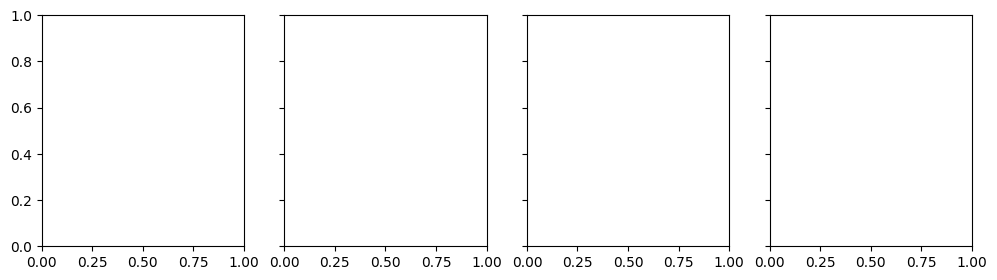

In [8]:
fig, axes = plt.subplots(1,4, sharey=True, figsize=(12,3))

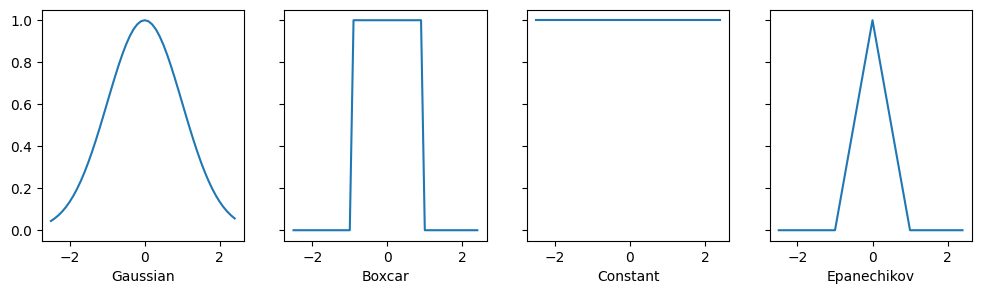

In [9]:
kernels = (gaussian, boxcar, constant, epanechikov)
names = ('Gaussian', 'Boxcar', 'Constant', 'Epanechikov')
x = torch.arange(-2.5, 2.5, 0.1)
for kernel, name, ax in zip(kernels, names, axes):
    ax.plot(x.detach().numpy(), kernel(x).detach().numpy())
    ax.set_xlabel(name)
fig

In [10]:
### Generate some training data:

def f(x):
    return 2 * torch.sin(x) + x

n = 40
x_train, _ = torch.sort(torch.rand(n) * 5)
y_train = f(x_train) + torch.randn(n)
x_val = torch.arange(0, 5, 0.1)
y_val = f(x_val)

### 11.2.2 Attention Pooling via Nadaraya-Watson Regression

In [12]:
def nadaraya_watson(x_train, y_train, x_val, kernel):
    dists = x_train.reshape((-1, 1)) - x_val.reshape((1, -1))
    # Each column/row corresponds to each query/key
    k = kernel(dists).type(torch.float32)
    # Normalization over keys for each query
    attention_w = k / k.sum(0)
    y_hat = y_train@attention_w
    return y_hat, attention_w

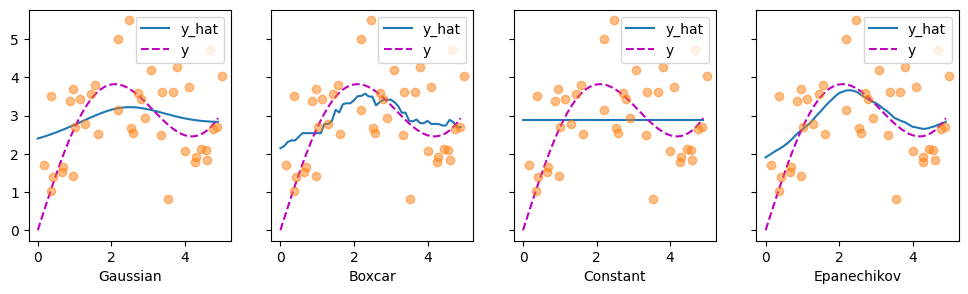

In [13]:
def plot(x_train, y_train, x_val, y_val, kernels, names, attention=False):
    fig, axes = plt.subplots(1, 4, sharey=True, figsize=(12, 3))
    for kernel, name, ax in zip(kernels, names, axes):
        y_hat, attention_w = nadaraya_watson(x_train, y_train, x_val, kernel)
        if attention:
            pcm = ax.imshow(attention_w.detach().numpy(), cmap='Reds')
        else:
            ax.plot(x_val, y_hat)
            ax.plot(x_val, y_val, 'm--')
            ax.plot(x_train, y_train, 'o', alpha=0.5);
        ax.set_xlabel(name)
        if not attention:
            ax.legend(['y_hat', 'y'])
    if attention:
        fig.colorbar(pcm, ax=axes, shrink=0.7)

plot(x_train, y_train, x_val, y_val, kernels, names)

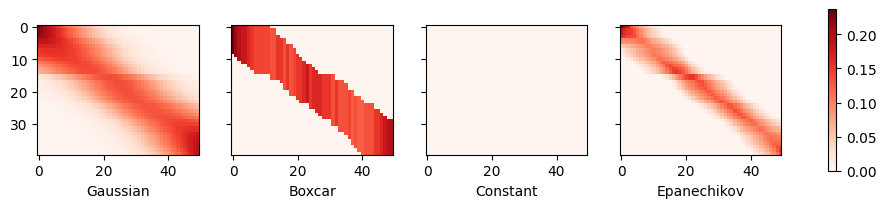

In [14]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)

### 11.2.3 Adatping Attention Pooling

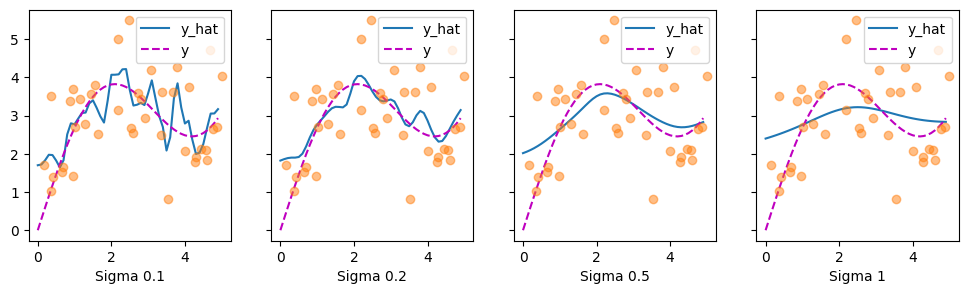

In [15]:
sigmas = (0.1, 0.2, 0.5, 1)
names = ['Sigma ' + str(sigma) for sigma in sigmas]

def gaussian_with_width(sigma):
    return (lambda x: torch.exp(-x**2 / (2*sigma**2)))

kernels = [gaussian_with_width(sigma) for sigma in sigmas]
plot(x_train, y_train, x_val, y_val, kernels, names)

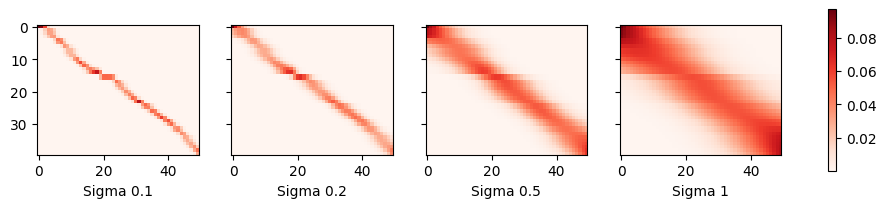

In [16]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)

### 11.2.4

As we can see from the above, using handcrafted attention mechanisms are a hyperparameter that work better for some data samples and perhaps not for others. This can be an issue if the train and test data are different. Like with the handcrafted convolutional filters, attention mechanisms perform better when they are learned.

## 11.3 Attention Scoring Functions

### 11.3.1 Dot Product Attention

$$\alpha(q,k_i) = \frac{-1}{2}||q-k_i||^2$$
$$ = q^Tk_i - \frac{1}{2}||k_i||^2 - \frac{1}{2}||q||^2$$

Things to note:
* Last term depends on q alone: can be dropped when normalizing 
* Batch Norm and Layer Norm lead to activations w well bounded anad roughly constant norms so $||k_i||$ is also roughly equal and can be ignored

This leaves us with the following, simplified attention mech:

$$ a(q, k_i) = q^Tk_i$$

However, if we want to ensure positive values by exponentiation, we must ensure that the values of the dot product do not cause numerical stability issues. If we have q and k_i are d-dimensional vectors each with zero mean and unit variance then we have a scalar of zero mean and variance of d. We can thus rescale the attention score function such that the resulting vector is zero mean and unit variance by:

$$ a(q, k_i) = q^T k_i /\sqrt{d}$$

With normalization:

$$ a(q, k_i) = \frac{\exp(q^T k_i /\sqrt{d})}{\sum_{j=1}\exp(q^T k_i /\sqrt{d})} $$


### 11.3.2 Convenience Functions

Need to be robust for:

* variable seqlens
* mini-batches
* masked/padded tokens

In [17]:
def masked_softmax(X, valid_lens): 
    """Perform softmax operation by masking elements on the last axis."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [20]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.5098, 0.4902, 0.0000, 0.0000],
         [0.4598, 0.5402, 0.0000, 0.0000]],

        [[0.3719, 0.3254, 0.3027, 0.0000],
         [0.3978, 0.3761, 0.2261, 0.0000]]])

In [30]:
Q = torch.ones((2, 3, 4))
K = torch.ones((2, 4, 6))

z = Q@K
y = torch.bmm(Q, K)
# Shape = (BSZ, Q.shape[1], K.shape[2])

torch.all(z == y)

tensor(True)

### 11.3.3 Scaled Dot-Product Attention

In terms of mini-batches, the scaled dot product attention becomes the following.

Terms:
* $Q \in \mathbb{R}^{n x d}$
* $K \in \mathbb{R}^{m x d}$
* $V \in \mathbb{R}^{m x v}$

$$ \text{softmax}(\frac{QK^T}{\sqrt{d}})V \in \mathbb{R}^{n x v} $$

In [33]:
class DotProductAttention(nn.Module):  #@save
    """Scaled dot product attention."""
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / d**0.5
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [36]:
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = DotProductAttention(dropout=0.5)
attention.eval()
assert attention(queries, keys, values, valid_lens).shape == (2, 1, 4)

### 11.3.4 Additive Attention

$$ a(q, k) = w_v^Ttanh(W_qq + W_kk) \in \mathbb{R} $$

This takes differet dimension and projects onto h dimensional so that they can be added and transformed into a scalar. 

In [37]:
class AdditiveAttention(nn.Module):  #@save
    """Additive attention."""
    def __init__(self, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.LazyLinear(num_hiddens, bias=False)
        self.W_q = nn.LazyLinear(num_hiddens, bias=False)
        self.w_v = nn.LazyLinear(1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # After dimension expansion, shape of queries: (batch_size, no. of
        # queries, 1, num_hiddens) and shape of keys: (batch_size, 1, no. of
        # key-value pairs, num_hiddens). Sum them up with broadcasting
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # There is only one output of self.w_v, so we remove the last
        # one-dimensional entry from the shape. Shape of scores: (batch_size,
        # no. of queries, no. of key-value pairs)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # Shape of values: (batch_size, no. of key-value pairs, value
        # dimension)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [38]:
queries = torch.normal(0, 1, (2, 1, 20))

attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens).shape == (2, 1, 4)

/home/dxk/miniconda3/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


True

## 11.4 The Bahdanau Attention Mechanism

### 11.4.1 Model

Context variable c instead of being just the last hidden state representation of the encoder (which is static throughout the decoding phase), becomes a dynamic vector that instead is a function of decoded states and last hidden state. 

$c_{t'}$ is iteratively updated after each decoding step in the following attention pooling operation:

$$ c_{t'} = \sum_{t=1}^T \alpha(s_{t'-1}, h_t)h_t$$

Where s is the query and h is the key and value. Looking for the alignment between the so far decoded states and the hidden state. 

## 11.5 Multi-Head Attention

What if we allowed the model to learn dependencies spanning various ranges? The same way that in convolutional nets, having multiple channels allows the model to learn multiple different feature masks, the multi-head attention allows for different relational dependencies to be learned, which in return allows for a richer input representation.

### 11.5.1 Model

Terms:
* $q \in \mathbb{R}^{d_q}$
* $k \in \mathbb{R}^{d_k}$
* $v \in \mathbb{R}^{d_v}$
* $W_i^{(q)} \in \mathbb{R}^{p_q x d_q}$
* $W_i^{(k)} \in \mathbb{R}^{p_k x d_k}$
* $W_i^{(v)} \in \mathbb{R}^{p_v x d_v}$


Each attention head $h_i$ is defined according to 

$$ h_i = f(W_i^{(q)}q, W_i^{(k)}k, W_i^{(v)}v)$$

The multiple heads are aggregated with another learned affine transformation given by:

$$ W_o * concat([h1 ... h_h]) \in \mathbb{R}^{p_o} $$

## Class Notes

### The Transformer

03/22/2023


